# Barents Sea example

In this notebook we want to attempt a few things in the Barents Sea as an example:

- TS and volume distributions over 2014
- TS and volume distributinos over the 5-year period
- specific properties and their variation with T and S (T will be on x axis, heat flux sum on y-axis as an example, or summed advective flux on y-axis)
- label water masses or think about what can be seen in these TS diagrams

### Import packages, libraries, functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from ts2dte import ts2dte

### Read grid and masks

In [2]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [3]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [4]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

In [5]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [6]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [7]:
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)
SZ! (1, 900, 540)
shape of fld: (1, 900, 540)
(1, 270, 270)
(1, 270, 180)
(1, 270, 450)
(1, 1350, 270)
compact shape (1, 1350, 270)


In [8]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [9]:
wetmask = mygrid['hFacC']

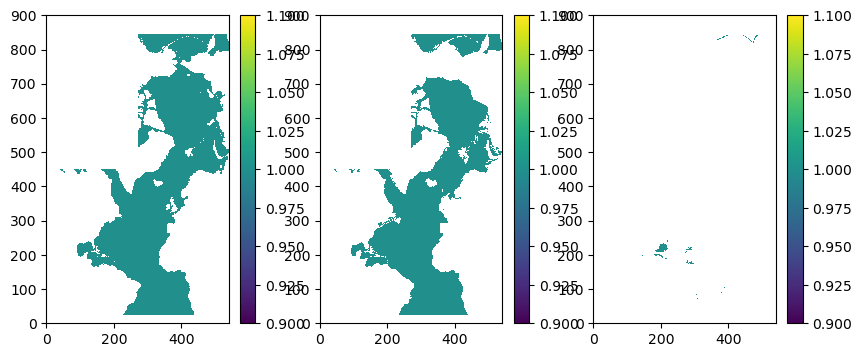

In [10]:
fig = plt.figure()

ax = fig.add_subplot(131)
hfactest = get_aste_tracer(mygrid['hFacC'][0],nfx,nfy)[0]
hfactest[450:,:270] = np.nan
cb = ax.pcolormesh(hfactest)
# plt.colorbar()
plt.colorbar(cb)

ax = fig.add_subplot(132)
hfactest = get_aste_tracer(mygrid['hFacC'][10],nfx,nfy)[0]
hfactest[450:,:270] = np.nan
cb = ax.pcolormesh(hfactest)
plt.colorbar(cb)

ax = fig.add_subplot(133)
hfactest = get_aste_tracer(mygrid['hFacC'][-1],nfx,nfy)[0]
hfactest[450:,:270] = np.nan
cb = ax.pcolormesh(hfactest)
plt.colorbar(cb)

In [ ]:
print(mygrid['hFacC'][20])

In [ ]:
wetmsktest = get_aste_tracer(wetmask[10],nfx,nfy)[0]
wetmsktest[450:,:270] = np.nan
plt.pcolormesh(wetmsktest*tmp1)
plt.colorbar()

In [ ]:
dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

In [ ]:
iB = 6   # for Barents
myMask = mskBasin.copy()
myMask[myMask != iB] = np.nan

### Get the timesteps we want

In [ ]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600
startyr = 2002
endyr = 2019

days_reg = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
days_leap = np.array([31,29,31,30,31,30,31,31,30,31,30,31])
days_reg = days_reg*24*3600/dt
days_leap = days_leap*24*3600/dt

years = np.arange(startyr,endyr,1)

# make an array of all the filenames before cumsum
fnames = np.array([],dtype=int)

for year in years:
    if is_leap(year):
        fnames = np.append(fnames,days_leap)
    else:
        fnames = np.append(fnames,days_reg)
fnames = np.cumsum(fnames)

In [ ]:
# now get this specific year, we want December 2014
# what if we want
months = np.arange(1,13,1)   # all the months of 2014, we also want the first month of 2015 so we can do tendency for 12/2014
year = 2014
tsstrs = np.array([])
datetimes = np.array([])     # make an array of datetime values to store
f_toread = np.array([],dtype=int)
for inf in fnames:
    thisfile = ts2dte(inf,deltat=600,startyr=2002,startmo=1,startdy=1)
    if thisfile.year == year and thisfile.month in months: 
        #print(thisfile)  # this would be used as the second time step for the month of November, not what we want
        datetimes = np.append(datetimes,thisfile)
        f_toread = np.append(f_toread,int(inf))

t_day = f_toread.astype(str)
tsstr = np.array([str(item).zfill(10) for item in t_day])

# we also want month 1 of 2015
months = 1
year = 2015
f_toread = np.array([],dtype=int)
for inf in fnames:
    thisfile = ts2dte(inf,deltat=600,startyr=2002,startmo=1,startdy=1)
    if thisfile.year == year and thisfile.month == months: 
        #print(thisfile)  # this would be used as the second time step for the month of November, not what we want
        datetimes = np.append(datetimes,thisfile)
        f_toread = np.append(f_toread,int(inf))

t_day = f_toread.astype(str)
t_day = np.array([str(item).zfill(10) for item in t_day])
tsstr = np.append(tsstr,t_day)

print(tsstr)
print(datetimes)

### Isolate the volumes

In [ ]:
# ocean and ice
AB_gT=0
debug = False

In [ ]:
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print(vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    #t2 = tsstr[t+1]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    SIheff,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])
    SIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[2])

    # do differencing
    #dETAN_dt =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt  # change naming to dEtan_dt  m/s
    #dSIheff_dt =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt
    #dSIhsnow_dt = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt

    # choose by basin
    # select by existing basin in mskBasin
    ETAN = np.reshape(ETAN,(ny,nx))
    #dETAN_dt = np.reshape(dETAN_dt,(ny,nx)) * myMask
    #dSIheff_dt = np.reshape(dSIheff_dt,(ny,nx)) * myMask
    #dSIhsnow_dt = np.reshape(dSIhsnow_dt,(ny,nx)) * myMask

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC
            tmp2 = tmp1/mk3D_mod(DD,tmp1)
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)
            
        tmpvol = tmp2 * mk3D_mod(ETAN, tmp2) * mk3D_mod(RAC, hfC)  # removed multiply by rhoconst to get volume alone

    vol[t,:,:,:] = tmpvol

print(vol.shape)

### Now we can read and bin thetadr and saltdr

In [ ]:
dirrun_small = "/scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"

binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = binsTH[:,:,0].flatten()
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

binsSLT = rdmds(dirrun_small + "layers1SLT", -1)
binsSLT_edges = binsSLT[:,:,0].flatten()
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

In [ ]:
myMask[np.newaxis,np.newaxis,:,:].shape

In [ ]:
# read in the initial model T-S fields
# create an array to store the values at all time steps
fileTS = np.zeros((len(tsstr),2,nz,ny,nx))
print(fileTS.shape)

# read each of the files from the list
for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = int(t1)

    # read the file
    thisfileTS = rdmds(dirIn + "budg3d_snap_set2",read)    # dr values, z, y, x
    thisfldListTS = parsemeta(dirIn + "budg3d_snap_set2." + tsstr[t] + ".meta")["fldList"]
    
    thisfileTS = thisfileTS.reshape(2,nz, ny, nx)

    fileTS[t,:,:,:,:] = thisfileTS

In [ ]:
# we should unweight these before we add them to the dataset
DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))
temp = fileTS[:,0,:,:,:] / DRF3d
salt = fileTS[:,1,:,:,:] / DRF3d

In [ ]:
wetmask.shape

In [ ]:
temp[-1,9,:,:].shape

In [ ]:
# should be hardcoded for depth
k = 0
tmp = temp[-1,k,:,:] * wetmask[k,:,:]
slt = salt[-1,k,:,:] * wetmask[k,:,:]

# tmp   # mask out the corner
print(tmp.shape)

In [ ]:
tmp1 = get_aste_tracer(slt,nfx,nfy)[0]
tmp1[450:,:270] = np.nan
plt.pcolormesh(tmp1)
plt.colorbar()

In [ ]:
mskBasin.shape

In [ ]:
tmp[mskBasin != 6] = np.nan
slt[mskBasin != 6] = np.nan

In [ ]:
tmp2 = get_aste_tracer(tmp,nfx,nfy)[0]
tmp2[450:,:270] = np.nan
plt.pcolormesh(tmp2)
plt.colorbar()
plt.xlim(400,540)
plt.ylim(400,600)

In [ ]:
slt2 = get_aste_tracer(slt,nfx,nfy)[0]
slt2[450:,:270] = np.nan
plt.pcolormesh(slt2)
plt.colorbar()
plt.xlim(400,540)
plt.ylim(400,600)

In [ ]:
plt.scatter(slt2.flatten(),tmp2.flatten())

In [ ]:
wetmask[wetmask == 0] = np.nan

In [ ]:
dims = ("iteration","z","compact_x","compact_y")
coords = {"iteration" : datetimes,
          "z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsT = {'title' : 'wighted T data from budg3d_snap_set2 example from official ASTE',
         'standard_name' : 'temperature',
         'units' : 'degree_c'}

attrsS = {'title' : 'weighted S data from budg3d_snap_set2 example from official ASTE',
         'standard_name' : 'salinity',
         'units' : 'ppt'}

attrsVol = {'title' : 'volume calculated from budg2d_snap_set1',
         'standard_name' : 'volume (m^3)',
         'units' : 'ppt'}

In [ ]:
temp = xr.DataArray(data = temp*wetmask[np.newaxis,:,:,:],
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

salt = xr.DataArray(data = temp*wetmask[np.newaxis,:,:,:],
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

volume = xr.DataArray(data = vol*wetmask[np.newaxis,:,:,:],
                    dims = dims,
                    coords = coords,
                    attrs = attrsVol)

In [ ]:
ds = xr.Dataset({'theta': temp, 'salinity': salt, 'volume':volume})

In [ ]:
plt.pcolormesh(get_aste_tracer(ds.theta.values[-1,0,:,:],nfx,nfy)[0])

### Do the binning

In [ ]:
# let's create a binning function with numpy
def bin_array(arr, bin_edges):
    flattened_arr = arr.flatten()
    bin_indices = np.digitize(flattened_arr, bin_edges)
    bin_indices_3d = bin_indices.reshape(arr.shape)
    
    return bin_indices_3d-1

In [ ]:
# create this as an xarray and add it to the dataset
# now the bins should go up to 112
binned_theta = bin_array(ds.theta.values,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
# print(np.nanmin(binned_theta),np.nanmin(ds.theta.values),binsTH_edges[int(np.nanmin(binned_theta))])
binned_salinity = bin_array(ds.salinity.values,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan        # not sure about this one
# print(np.nanmin(binned_salinity),np.nanmin(ds.salinity.values),binsSLT_edges[int(np.nanmin(binned_salinity))])

binned_temp = xr.DataArray(data = binned_theta*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

binned_salt = xr.DataArray(data = binned_salinity*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

In [ ]:
ds["theta_binned"] = binned_temp
ds["salinity_binned"] = binned_salt

In [ ]:
binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1,1)
dS = dS.reshape(112,112,1,1)

In [ ]:
ds

In [ ]:
# select for one time step ie December 2014
ds = ds.sel(iteration = '2015-01-01T00:00:00.000000000')
ds

In [ ]:
del binned_temp, binned_salt, temp, salt, volume

In [ ]:
# try just for december
# Initialize mesh
starttime = time.time()

mesh = np.zeros((nS, nT, ny, nx))   # binsTH_edges-1

# # Iterate over all points in the domain
for i in range(ny):
    if i%250 == 0:
        print(i,"in",time.time()-starttime)
    for j in range(nx):
        thiscol = ds.volume[:, i, j].values
        thissalt = ds.salinity_binned[:, i, j].values
        thistemp = ds.theta_binned[:, i, j].values

        thiscol = thiscol[~np.isnan(thiscol)]
        thissalt = thissalt[~np.isnan(thissalt)].astype(int)
        thistemp = thistemp[~np.isnan(thistemp)].astype(int)

        # if not a dry point, add volume
        if len(thiscol)>0:
            mesh[thissalt,thistemp,i,j] += thiscol

mesh /= dT
mesh /= dS

In [ ]:
# add the mesh to the dataset
dims = ("i_Tbins","i_Sbins","compact_x","compact_y")
# not sure if we want the bin centers I think so 
coords = {"i_Tbins" : np.arange(0,nT,1),
          "i_Sbins" : np.arange(0,nS,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrs = {'title' : 'binned volume data within T and S bins for whole ASTE',
         'standard_name' : 'binnev volume',
         'units' : 'm^3/(deg C PSU)'}

In [ ]:
# syntax
mesh2 = xr.DataArray(data = mesh,
                    dims = dims,
                    coords = coords,
                    attrs = attrs)

In [ ]:
ds["volume_mesh"] = mesh2

In [ ]:
del mesh

### Try plotting

In [ ]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = mpl.cm.get_cmap("viridis",14).copy()
cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

In [ ]:
ds

In [ ]:
Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

In [ ]:
# add the rho lines
# add the polygons and the points
smin = 26 - (0.01 * 26)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 36. + (0.01 * 36.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2.5 + (0.1 * -2.5)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 7.5 + (0.1 * 7.5)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 30
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2.5,7.5,ydim)
si = np.linspace(26,36,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

# convert to practical/potential - ask An if we need to do this? What model output?
# long = 73.5089
# lat = -66.8245
# ti = gsw.pt_from_CT(si1,ti1)
# si = gsw.SP_from_SA(si1,0,long,lat)

In [ ]:
np.nansum(test_vol)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.5,levels=np.arange(22,29,1))
cl=ax.clabel(cs,fontsize=10,inline=False,fmt="%.2f")

# add volume distribution
title = "Barents 12/2014"
test_vol = ds['volume_mesh'].values[:,:,mskBasin==6]
test_vol = np.nansum(test_vol,axis=2)
cb = ax.pcolormesh(Sbin,Tbin,np.log10(test_vol),zorder=3)

# labels
fig.colorbar(cb)
ax.set_title(title)
ax.set_xlabel("S")
ax.set_ylabel("T")
ax.grid()
# ax.set_xlim(28,36)
# ax.set_ylim(-2.5,7.5)

In [ ]:
testt = ds.theta.values[-1,:,:,:][mskBasin_3D.values == 6]
tests = ds.salinity.values[-1,:,:,:][mskBasin_3D.values == 6]
plt.scatter(tests,testt,s=0.3,marker="o")

In [ ]:
ds.theta.values.shape